In [1]:
import dynalearn
import pickle
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tqdm
import os

In [2]:
def chain_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_node(i)
        g.add_edge(i - 1, i)
    g.name = 'chain_n{0}'.format(n)
    return g

def complete_graph(n):
    g = nx.complete_graph(n)
    g.name = 'complete_n{0}'.format(n)
    return g

def star_graph(n):
    g = nx.Graph()
    g.add_node(0)
    for i in range(1, n):
        g.add_edge(0, i)
    g.name = 'star_n{0}'.format(n)
    return g

def regular_graph(n, d):
    g = nx.random_regular_graph(d, n)
    g.name = 'regular_n{0}_d{1}'.format(n, d)
    return g

def empty_graph(n):
    g = nx.empty_graph(n)
    g.name = 'empty_n{0}'.format(n)
    return g

def BA_tree_graph(n):
    g = nx.barabasi_albert_graph(n, 1)
    g.name = 'ba_tree_n{0}'.format(n)
    return g

def ER_graph(n, p):
    g = nx.gnp_random_graph(n, p)
    g.name = 'er_n{0}_p{1}'.format(n, p)
    return g

In [8]:
# Generating the network
n_nodes = 500
inf_prob = 0.1
rec_prob = 0.08
T = 10
batch_size = None

train_sample = 100000
val_sample = 1000

approach = "gatpred"
# graph = complete_graph(n_nodes)
# graph = chain_graph(n_nodes)
# graph = empty_graph(n_nodes)
# graph = star_graph(n_nodes)
# graph = BA_tree_graph(n_nodes)
graph = ER_graph(n_nodes, 0.02)

f_prefix = 'data/' + approach + "_" + graph.name + "_SIS_inf{0}_rec{1}".format(inf_prob, rec_prob)
if not os.path.exists(f_prefix):
    os.mkdir(f_prefix)


train_generator = dynalearn.datasets.SISGenerator(graph, inf_prob, rec_prob, batch_size,
                                                  init_param=None, shuffle=True,
                                                  with_structure=True)
train_generator.generate(train_sample, T, tqdm.tqdm_notebook)

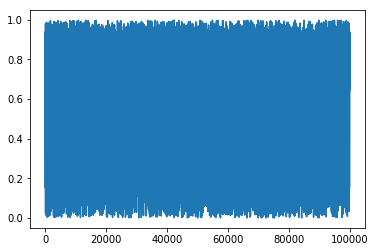

In [9]:
plt.plot(np.mean(train_generator.data_input, axis=1))
plt.show()

In [10]:
from dynalearn.models import GATMarkovPredictor

n_hidden = [128, 128]
n_heads = 4
wd = 0
dropout = 0.
model = GATMarkovPredictor(graph, n_hidden, n_heads, weight_decay=wd, dropout=dropout)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 500)          0                                            
__________________________________________________________________________________________________
graph_attention (GraphAttention (None, 512)          2048        input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
graph_attention_1 (GraphAttenti (None, 512)          263680      graph_attention[0][0]            
          

In [11]:

lr = 1e-4

optimizer = keras.optimizers.Adam(lr=lr)
# optimizer = keras.optimizers.SGD(lr=1e-4)
loss = keras.losses.binary_crossentropy
callbacks = [keras.callbacks.ReduceLROnPlateau(monitor='loss',factor=0.2,
                                               cooldown=5, patience=5,
                                               verbose=1),
             keras.callbacks.ModelCheckpoint(os.path.join(f_prefix, 'model'),
                                             monitor='loss',
                                             save_best_only=True,
                                             verbose=0)]
model._model.compile(optimizer, loss, metrics=['accuracy'])


In [12]:
history = model._model.fit_generator(train_generator,
                                     steps_per_epoch=1000,
                                     epochs=10,
                                     initial_epoch=0,
                                     verbose=1,
                                     callbacks=callbacks,
                                     shuffle=False)

Epoch 1/10


NameError: name 'data_input' is not defined

In [271]:
def increment_bit(x):

    val = x * 1
    i = np.where(x==0)[0][0]
    index = np.arange(len(x))
    val[index <= i] = 0
    val[i] = 1

    return val

def get_all_states(graph):
    N = graph.number_of_nodes()
    all_states = np.zeros([2**N, N])
    for i in range(1, 2**N):
        all_states[i, :] = increment_bit(all_states[i - 1, :])
    return all_states

def get_sample_from_all_states(graph, num_sample):
    N = graph.number_of_nodes()
    sampled_states = np.zeros([num_sample, N])
    for i in range(num_sample):
        sampled_states[i, :] = np.random.randint(0, 2, size=N)
    return sampled_states
    

def convert_to_multistate(states, n_state):
    new_states = np.zeros([*states.shape, n_state])
    new_states[states == 0] = [1, 0]
    new_states[states == 1] = [0, 1]
    return new_states
    

def get_SISLogTransProb(graph, states, infection_prob, recovery_prob):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    p = np.zeros([states.shape[0], N])
    for i, s in enumerate(states):
        local_p = np.zeros(N)
        inf_neighbors = np.matmul(A, s)
        local_p[s==0] = 1 - (1 - infection_prob)**inf_neighbors[s==0]
        local_p[s==1] = 1 - recovery_prob
        p[i, :] = np.log(local_p + 1e-15)
    return p
        
def get_SISMarkovMatrix(graph, infection_prob,recovery_prob):
    states = get_all_states(graph)
    logprob = get_SISLogTransProb(graph, states, infection_prob, recovery_prob)
    log_mm = np.matmul(states, logprob.T) + np.matmul(1 - states,np.log(1 - np.exp(logprob)).T)
    return log_mm


def get_LearnedMarkovMatrix(graph, model):
    states = get_all_states(graph)
    N = graph.number_of_nodes()
    A = nx.to_numpy_array(graph)
    log_mm = np.zeros([len(states), len(states)])
    if batch_size is None:
        for i, s in enumerate(states):
#             s = convert_to_multistate(s, 2)
            logprob = np.log(model.predict([s, A]) + 1e-15)
            log_mm[:, i] = np.matmul(states, logprob).reshape(states.shape[0]) \
                         + np.matmul(1 - states,np.log(1 - np.exp(logprob))).reshape(states.shape[0])
    else:
        logprob = np.log(model.predict(states) + 1e-15)
        log_mm = np.matmul(states, logprob) + np.matmul(1 - states,np.log(1 - np.exp(logprob)))
    
    return log_mm
    
    
def bit_to_value(array):
    d = array.shape[0]
    bit = 2**np.arange(d)
    return np.sum(array * bit)

def get_dataOccurence(graph, generator):
    N = graph.number_of_nodes()
    past = get_all_states(graph)
    occurence = np.zeros([2**N, 2**N])
    
    for i in range(len(generator)):
        inputs = generator.data_input[i, :]
        targets = generator.data_target[i, :]
        i, j = int(bit_to_value(targets)), int(bit_to_value(inputs))
        
        occurence[i, j] += 1
    
    sparcity_matrix = np.zeros(occurence.shape)
    sparcity_matrix[occurence>0] = 1
    return np.log(occurence / np.sum(occurence) + 1e-15), np.sum(sparcity_matrix) / 2**(2*N)


def get_dataMarkovMatrix(occurence, real_mm, learned_mm):
    n, m = occurence.shape
    indata_sismm = []
    indata_learnedmm = []
    notindata_sismm = []
    notindata_learnedmm = []


    for i in range(n):
        for j in range(n):    
            if occurence[i, j] > -20:
                indata_sismm.append(max(real_mm[i, j], -100))
                indata_learnedmm.append(learned_mm[i, j])
            else:
                notindata_sismm.append(max(real_mm[i, j], -100))
                notindata_learnedmm.append(learned_mm[i, j])
    return np.array([indata_sismm, indata_learnedmm]).T,\
           np.array([notindata_sismm, notindata_learnedmm]).T

In [272]:
real_mm = get_SISMarkovMatrix(graph, inf_prob, rec_prob)
learned_mm = get_LearnedMarkovMatrix(graph, model._model)
data_occurence, sparcity = get_dataOccurence(graph, train_generator)
indata, notindata = get_dataMarkovMatrix(data_occurence, real_mm, learned_mm)

ValueError: Maximum allowed dimension exceeded

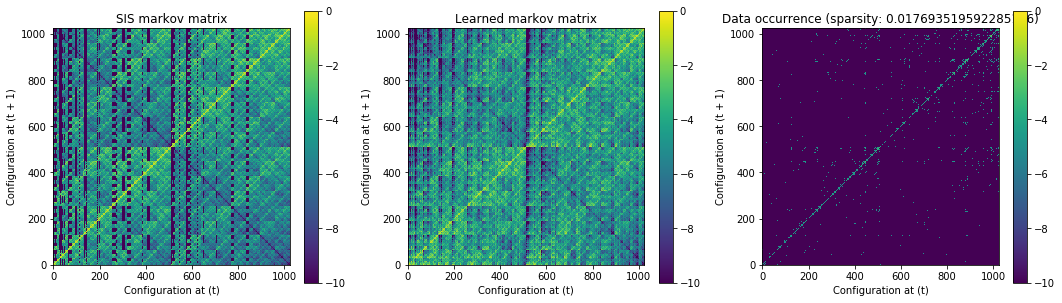

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

p0 = ax[0].imshow(np.log10(np.exp(real_mm)), origin='lower', vmin=-10, vmax=0)
ax[0].set_title('SIS markov matrix')
ax[0].set_xlabel('Configuration at (t)')
ax[0].set_ylabel('Configuration at (t + 1)')
plt.colorbar(p0, ax=ax[0])
p1 = ax[1].imshow(np.log10(np.exp(learned_mm)), origin='lower', vmin=-10, vmax=0)
ax[1].set_title('Learned markov matrix')
ax[1].set_xlabel('Configuration at (t)')
ax[1].set_ylabel('Configuration at (t + 1)')
plt.colorbar(p1, ax=ax[1])
p2 = ax[2].imshow(np.log10(np.exp(data_occurence)), origin='lower', vmin=-10, vmax=0)
ax[2].set_title('Data occurrence (sparsity: {0})'.format(sparcity))
ax[2].set_xlabel('Configuration at (t)')
ax[2].set_ylabel('Configuration at (t + 1)')
plt.colorbar(p2, ax=ax[2])
fig.savefig(f_prefix + 'markov_matrix.png')
plt.show()

In [273]:

def get_SIS_CLP(graph, infection_prob, recovery_prob, states, progress_bar=None):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    
    prob = np.zeros([states.shape[0], N])

    inf_neighbors = np.matmul(A, states.T).T
    
    sus_to_sus_prob = {i: [] for i in range(N)}
    sus_to_inf_prob = {i: [] for i in range(N)}
    inf_to_sus_prob = {i: [] for i in range(N)}
    inf_to_inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Probabilities')
    for i in range(states.shape[0]):
        s = states[i, :]
        
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            if s[j] == 0:
                sus_to_sus_prob[int(inf)].append((1 - infection_prob)**inf)
                sus_to_inf_prob[int(inf)].append(1 - (1 - infection_prob)**inf)
            else:
                inf_to_sus_prob[int(inf)].append(recovery_prob)
                inf_to_inf_prob[int(inf)].append(1 - recovery_prob)

    if progress_bar:
        bar.close()
    
    return sus_to_sus_prob, sus_to_inf_prob, inf_to_sus_prob, inf_to_inf_prob


def get_learned_CLP(graph, model, states, progress_bar=None):
    N = graph.number_of_nodes()
    
    A = nx.to_numpy_array(graph) + np.eye(N)
    
    prob = np.zeros([states.shape[0], N])

    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Transitions')
    for i, s in enumerate(states):
        p = model.predict([s, A], steps=1) + 1e-15
        prob[i, :] = p[:,0]
        if progress_bar:
            bar.update()
    
    if progress_bar:
        bar.close()
    
    sus_to_sus_prob = {i: [] for i in range(N)}
    sus_to_inf_prob = {i: [] for i in range(N)}
    inf_to_sus_prob = {i: [] for i in range(N)}
    inf_to_inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Probabilities')
    for i in range(states.shape[0]):
        s = states[i, :]
        
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            if s[j] == 0:
                sus_to_sus_prob[int(inf)].append(1 - prob[i, j])
                sus_to_inf_prob[int(inf)].append(prob[i, j])
            else:
                inf_to_sus_prob[int(inf) - 1].append(1 - prob[i, j])
                inf_to_inf_prob[int(inf) - 1].append(prob[i, j])
    
    if progress_bar:
        bar.close()
    
    return sus_to_sus_prob, sus_to_inf_prob, inf_to_sus_prob, inf_to_inf_prob

def get_SIS_MLP(graph, infection_prob, recovery_prob, states, progress_bar=None):
    A = nx.to_numpy_array(graph)
    N = A.shape[0]
    
    prob = np.zeros([states.shape[0], N])

    inf_neighbors = np.matmul(A, states.T).T
    
    sus_prob = {i: [] for i in range(N)}
    inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Probabilities')
    for i in range(states.shape[0]):
        s = states[i, :]
        
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            if s[j] == 0:
                sus_prob[int(inf)].append((1 - infection_prob)**inf)
                inf_prob[int(inf)].append(1 - (1 - infection_prob)**inf)
            else:
                sus_prob[int(inf)].append(recovery_prob)
                inf_prob[int(inf)].append(1 - recovery_prob)

    if progress_bar:
        bar.close()
    
    return sus_prob, inf_prob

def get_learned_MLP(graph, model, states, progress_bar=None):
    N = graph.number_of_nodes()
    A = nx.to_numpy_array(graph) + np.eye(N)
    
    prob = np.zeros([states.shape[0], N])

    if batch_size is None:
        if progress_bar:
            bar = progress_bar(range(states.shape[0]), 'Transition')
        for i, s in enumerate(states):
            p = model.predict([s, A], steps=1) + 1e-15
            prob[i, :] = p[:,0]
            if progress_bar:
                bar.update()
        
        if progress_bar:
            bar.close()
    else:
        prob = model.predict(states) + 1e-15
    
    sus_prob = {i: [] for i in range(N)}
    inf_prob = {i: [] for i in range(N)}
    
    if progress_bar:
        bar = progress_bar(range(states.shape[0]), 'Probability')
    for i in range(states.shape[0]):
        s = states[i, :]
        
        inf_neighbors = np.matmul(A, s)
        if progress_bar:
            bar.update()
        for j, inf in enumerate(inf_neighbors):
            sus_prob[int(inf)].append(1 - prob[i, j])
            inf_prob[int(inf)].append(prob[i, j])
    
    if progress_bar:
        bar.close()
    
    return sus_prob, inf_prob

def get_num_local_transition(graph, in_states, out_states, progress_bar=None):
    N = graph.number_of_nodes()
    
    A = nx.to_numpy_array(graph) + np.eye(N)
    
#     sus_to_sus_sparcity = {i: 0 for i in range(N)}
#     sus_to_inf_sparcity = {i: 0 for i in range(N)}
#     inf_to_sus_sparcity = {i: 0 for i in range(N)}
#     inf_to_inf_sparcity = {i: 0 for i in range(N)}
    s_s_sparcity = [0 for i in range(N)]
    s_i_sparcity = [0 for i in range(N)]
    i_s_sparcity = [0 for i in range(N)]
    i_i_sparcity = [0 for i in range(N)]
    
    if progress_bar:
        bar = progress_bar(range(in_states.shape[0]), 'Sparcity')
        
    for i in range(in_states.shape[0]):
        in_s = in_states[i, :]
        out_s = out_states[i, :]
        
        inf_neighbors = np.matmul(A, in_s)
        for j, inf in enumerate(inf_neighbors):
            if in_s[j] == 0 and out_s[j] == 0:
                s_s_sparcity[int(inf)] += 1
            elif in_s[j] == 0 and out_s[j] == 1:
                s_i_sparcity[int(inf)] += 1
            elif in_s[j] == 1 and out_s[j] == 0:
                i_s_sparcity[int(inf) - 1] += 1
            else:
                i_i_sparcity[int(inf) - 1] += 1
        if progress_bar:
            bar.update()
    
    if progress_bar:
        bar.close()

    s_s_sparcity = {i: s / np.sum(s_s_sparcity) for i, s in enumerate(s_s_sparcity)}
    s_i_sparcity = {i: s / np.sum(s_i_sparcity) for i, s in enumerate(s_i_sparcity)}
    i_s_sparcity = {i: s / np.sum(i_s_sparcity) for i, s in enumerate(i_s_sparcity)}
    i_i_sparcity = {i: s / np.sum(i_i_sparcity) for i, s in enumerate(i_i_sparcity)}
    
    return s_s_sparcity, s_i_sparcity, i_s_sparcity, i_i_sparcity

In [274]:
def plot_prob_vs_l(prob, ax, marker, linestyle, color, fill_color=None, label=None):
    if fill_color is None:
        fill_color = color
        
            
    keys = prob.keys()
    x = np.array([i for i in keys])
    y = np.array([np.mean(prob[i]) if len(prob)>0 else 0 for i in keys])
    
    err_y = np.array([np.std(prob[i]) if len(prob)>0 else 0  for i in keys])
    ax.fill_between(x, y - err_y, y + err_y, color=fill_color, alpha=0.3)
    ax.plot(x, y, marker=marker, ls=linestyle, c=color, label=label, lw=3)
    return x, y

/home/charles/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


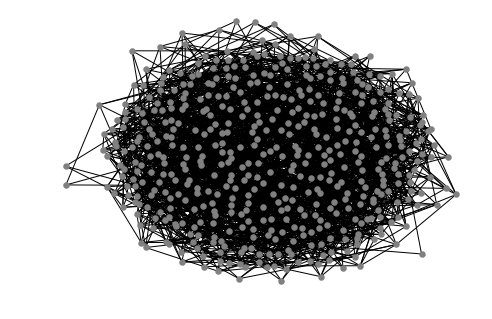

In [275]:
nx.draw_kamada_kawai(graph, node_size=20, node_color="grey", linewidths=2)
plt.show()


In [276]:
# states = get_all_states(graph)
# states = get_sample_from_all_states(graph, 10000)
states = train_generator.data_input[:1000]

s_s_real, s_i_real, i_s_real, i_i_real = get_SIS_CLP(graph, inf_prob, rec_prob, states)
s_s_lear, s_i_lear, i_s_lear, i_i_lear = get_learned_CLP(graph, model._model, states,
                                                         tqdm.tqdm_notebook)
s_s_trans, s_i_trans, i_s_trans, i_i_trans = get_num_local_transition(graph,
                                                                      train_generator.data_input,
                                                                      train_generator.data_target,
                                                                      tqdm.tqdm_notebook)


/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/charles/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


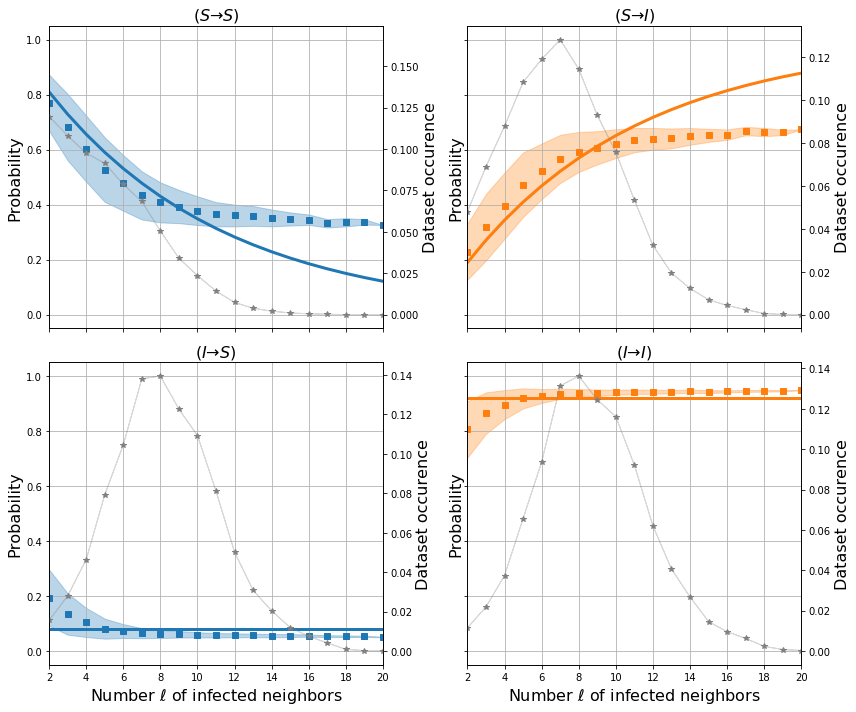

In [277]:
fig, ax = plt.subplots(2, 2, figsize=(12, 10), sharex=True, sharey=True)
axx = ax.copy()

axx[0, 0] = ax[0, 0].twinx()
axx[0, 1] = ax[0, 1].twinx()
axx[1, 0] = ax[1, 0].twinx()
axx[1, 1] = ax[1, 1].twinx()

plot_prob_vs_l(s_s_real, ax[0, 0], 'None', '-', '#1f77b4', 'grey')
plot_prob_vs_l(s_i_real, ax[0, 1], 'None', '-', '#ff7f0e', 'grey')
plot_prob_vs_l(i_s_real, ax[1, 0], 'None', '-', '#1f77b4', 'grey')
plot_prob_vs_l(i_i_real, ax[1, 1], 'None', '-', '#ff7f0e', 'grey')

plot_prob_vs_l(s_s_lear, ax[0, 0], 's', 'None', '#1f77b4')
plot_prob_vs_l(s_i_lear, ax[0, 1], 's', 'None', '#ff7f0e')
plot_prob_vs_l(i_s_lear, ax[1, 0], 's', 'None', '#1f77b4')
plot_prob_vs_l(i_i_lear, ax[1, 1], 's', 'None', '#ff7f0e')


plot_prob_vs_l(s_s_trans, axx[0, 0], '*', 'None', 'grey')
plot_prob_vs_l(s_i_trans, axx[0, 1], '*', 'None', 'grey')
plot_prob_vs_l(i_s_trans, axx[1, 0], '*', 'None', 'grey')
plot_prob_vs_l(i_i_trans, axx[1, 1], '*', 'None', 'grey')

ax[0, 0].set_ylabel(r'Probability', fontsize=16)
ax[0, 1].set_ylabel(r'Probability', fontsize=16)
ax[1, 0].set_ylabel(r'Probability', fontsize=16)
ax[1, 1].set_ylabel(r'Probability', fontsize=16)

axx[0, 0].set_ylabel(r'Dataset occurence', fontsize=16)
axx[0, 1].set_ylabel(r'Dataset occurence', fontsize=16)
axx[1, 0].set_ylabel(r'Dataset occurence', fontsize=16)
axx[1, 1].set_ylabel(r'Dataset occurence', fontsize=16)


ax[0, 0].set_title(r'$(S \to S)$', fontsize=16)
ax[0, 1].set_title(r'$(S \to I)$', fontsize=16)
ax[1, 0].set_title(r'$(I \to S)$', fontsize=16)
ax[1, 1].set_title(r'$(I \to I)$', fontsize=16)

ax[1, 0].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[1, 1].set_xlabel(r'Number $\ell$ of infected neighbors', fontsize=16)
ax[0, 0].set_xlim([min(dict(graph.degree).values()), max(dict(graph.degree).values())])
axx[0, 0].set_xlim([min(dict(graph.degree).values()), max(dict(graph.degree).values())])

ax[0,0].grid(True)
ax[0,1].grid(True)
ax[1,0].grid(True)
ax[1,1].grid(True)

plt.savefig(f_prefix + 'local_trans_prob.png')
plt.tight_layout()
plt.show()

In [264]:
s_s_trans

{0: 0.49536716393003366,
 1: 0.43914614036695326,
 2: 0.046157923852392584,
 3: 0.011439755954963285,
 4: 0.003939955239426521,
 5: 0.0017440598123241154,
 6: 0.001003582484853346,
 7: 0.000564453065342706,
 8: 0.000298947388984482,
 9: 0.00014552111583406323,
 10: 7.41677586958593e-05,
 11: 4.3333506336252616e-05,
 12: 2.4501848854882088e-05,
 13: 1.5686149858108634e-05,
 14: 9.809017193592999e-06,
 15: 7.408498217945767e-06,
 16: 5.007979242298535e-06,
 17: 4.138825820081434e-06,
 18: 2.19357768464316e-06,
 19: 1.4072007788276875e-06,
 20: 1.3244242624260587e-06,
 21: 1.0347064550203585e-06,
 22: 7.863769058154725e-07,
 23: 8.691534222171011e-07,
 24: 4.966590984097721e-07,
 25: 1.2416477460244303e-07,
 26: 1.2416477460244303e-07,
 27: 4.1388258200814336e-08,
 28: 4.1388258200814336e-08,
 29: 0.0,
 30: 0.0,
 31: 0.0,
 32: 0.0,
 33: 0.0,
 34: 0.0,
 35: 0.0,
 36: 0.0,
 37: 0.0,
 38: 0.0,
 39: 0.0,
 40: 0.0,
 41: 0.0,
 42: 0.0,
 43: 0.0,
 44: 0.0,
 45: 0.0,
 46: 0.0,
 47: 0.0,
 48: 0.0,

Regarder les probabilités de transition dans le dataset

Doubler la séquence

Accuracy dans keras?

Apprendre sur un réseau petit -> simuler sur un reseau plus gros

caractériser le scaling avec N

In [89]:
T = 1000

gt_mean = np.zeros(T)
learn_mean = np.zeros(T)

sis = dynalearn.dynamics.SISNetwork(graph, inf_prob, rec_prob, init_param=0.2)

A = nx.to_numpy_array(graph) + np.eye(n_nodes)
past = sis.states.copy()

for i in range(T):
#     sis.states = past
    sis.update()
    learn_p = model._model.predict([past, A]).reshape(n_nodes)
    learn_present = np.random.binomial(1, learn_p)
    gt_mean[i] = np.mean(sis.states)
    learn_mean[i] = np.mean(learn_present)
#     past = learn_present
    past = sis.states



InvalidArgumentError: Incompatible shapes: [32,32] vs. [32,100]
	 [[{{node graph_attention_4/add_1}} = Add[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"](graph_attention_4/leaky_re_lu_32/LeakyRelu, graph_attention_5/mul)]]

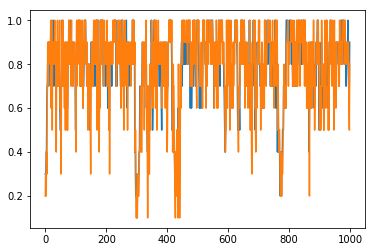

In [76]:
plt.plot(gt_mean)
plt.plot(learn_mean)
plt.show()